In [17]:
import sys
import os

# Assumes your notebook is in: latent-planning/notebooks/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [19]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
from models.tinycnn import TinyCNN
from utils.inpca import inpca_embed_intensive

In [21]:
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [22]:
# Download and prepare MNIST dataset
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='~/.mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/.mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [27]:
import os, numpy as np, torch, torch.nn.functional as F
os.makedirs(f"{project_root}/data", exist_ok=True)

checkpoints = [0, 1, 3, 5, 10, 20, 30, 40, 45, 50]

In [28]:
# Training block
# Save probs to ./data/probs_epoch{ep}.npy

def eval_probs(model, loader):
    """Return (N_test,10) softmax matrix for ALL test images."""
    model.eval()
    all_probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            probs = F.softmax(model(x), dim=1).cpu().numpy()
            all_probs.append(probs)
    return np.concatenate(all_probs)  # (10000, 10)

def eval_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

model = TinyCNN().to(device)


train_err = []          # 1 - accuracy on TRAIN set
test_err  = []          # 1 - accuracy on TEST  set


# ---------- 1. snapshot BEFORE training ----------
np.save(f"{project_root}/data/probs_epoch0.npy", eval_probs(model, test_loader))
print("Epoch 0 (untrained) acc =", eval_accuracy(model, test_loader))

train_err.append(1 - eval_accuracy(model, train_loader))
test_err .append(1 - eval_accuracy(model, test_loader))

coords_epoch = {}                            # epoch -> (N_test, 2)
label_full   = test_dataset.targets.numpy()  # same order as eval_probs

# ---------- 2. train model ----------
opt = torch.optim.SGD(model.parameters(), lr=1e-3)  # (or Adam, RMSprop, etc. Adam converges within 5 epochs)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(1, max(checkpoints)+1)):
    # --- train one epoch ---
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); opt.step()

    # --- evaluate on train and test sets ---
    train_acc = eval_accuracy(model, train_loader)
    test_acc  = eval_accuracy(model, test_loader)
    train_err.append(1 - train_acc)
    test_err .append(1 - test_acc)


    # --- if in checkpoints then record ---
    if epoch in checkpoints:
        acc = eval_accuracy(model, test_loader)
        print(f"Epoch {epoch} test accuracy: {acc:.4f}")
        probs = eval_probs(model, test_loader)
        np.save(f"{project_root}/data/probs_epoch{epoch}.npy", probs)
        coords3, _ = inpca_embed_intensive(probs)       # (10k,3)
        coords_epoch[epoch] = coords3[:, :2]             # keep x,y

Epoch 0 (untrained) acc = 0.138


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 test accuracy: 0.4495


  4%|▍         | 2/50 [05:47<1:56:37, 145.77s/it]

Epoch 3 test accuracy: 0.7233


  8%|▊         | 4/50 [11:26<1:50:10, 143.70s/it]

Epoch 5 test accuracy: 0.8478


 18%|█▊        | 9/50 [17:51<37:56, 55.53s/it]   

Epoch 10 test accuracy: 0.9040


 38%|███▊      | 19/50 [26:03<10:53, 21.07s/it]   

Epoch 20 test accuracy: 0.9317


 58%|█████▊    | 29/50 [34:18<06:46, 19.34s/it]   

Epoch 30 test accuracy: 0.9455


 78%|███████▊  | 39/50 [41:59<03:24, 18.62s/it] 

Epoch 40 test accuracy: 0.9554


 88%|████████▊ | 44/50 [48:22<03:44, 37.41s/it] 

Epoch 45 test accuracy: 0.9593


 98%|█████████▊| 49/50 [54:37<00:40, 40.34s/it] 

Epoch 50 test accuracy: 0.9626


100%|██████████| 50/50 [59:35<00:00, 71.52s/it] 


In [29]:
# Load probabilities
probs_list = [np.load(f"../data/probs_epoch{ep}.npy") for ep in checkpoints]

In [30]:
import matplotlib.pyplot as plt, os
from matplotlib.gridspec import GridSpec

os.makedirs("frames", exist_ok=True)

for epoch, Cxy in coords_epoch.items():
    fig = plt.figure(figsize=(6,6), dpi=120)
    gs  = GridSpec(2,1, height_ratios=[3,1], hspace=0.05)

    # top scatter ---------------------------------------------------
    ax0 = fig.add_subplot(gs[0])
    ax0.scatter(Cxy[:,0], Cxy[:,1],
                c=label_full, cmap='tab10', s=4)
    ax0.axis('off')
    ax0.set_title(f"InPCA – epoch {epoch}")

    # bottom error curve -------------------------------------------
    ax1 = fig.add_subplot(gs[1])
    ax1.plot(train_err, label="train err", alpha=0.6)
    ax1.plot(test_err , label="test err" , alpha=0.9)
    ax1.axvline(epoch, color='orange')
    ax1.set_xscale('log');  ax1.set_ylim(0,1)
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('% error')
    ax1.legend(frameon=False)

    fig.tight_layout()
    fig.savefig(f"frames/frame_{epoch:04d}.png")
    plt.close(fig)

/var/folders/3s/khd8zc512csgnd00hd4d3t4m0000gn/T/ipykernel_8526/547846504.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [39]:
import os
import glob
from shutil import copyfile

os.makedirs("frames_sequential", exist_ok=True)
files = sorted(glob.glob("frames/frame_*.png"))
for i, fname in enumerate(files):
    copyfile(fname, f"frames_sequential/frame_{i:04d}.png")

In [40]:
!which ffmpeg

/opt/homebrew/bin/ffmpeg


In [44]:
!ffmpeg -y -framerate 0.8 -i frames_sequential/frame_%04d.png -pix_fmt yuv420p inPCA_training.mp4

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

In [34]:
import subprocess

subprocess.run([
    "ffmpeg", "-y", "-framerate", "5",
    "-i", "frames/frame_%04d.png",
    "-pix_fmt", "yuv420p",
    "inPCA_training.mp4"
])

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

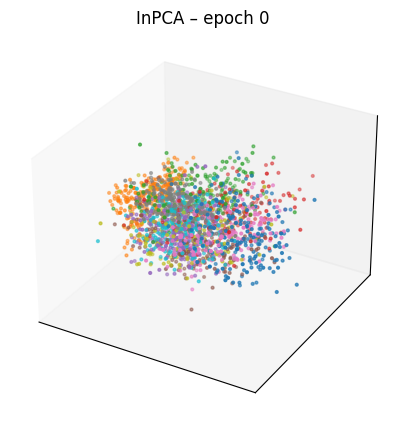

In [8]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401

# ----------- choose epoch to plot -----------
epoch_to_plot = 0                # 0, 20, 100 … repeat as wanted
P   = np.load(f"{project_root}/data/probs_epoch{epoch_to_plot}.npy")
lab = test_dataset.targets.numpy()     # true digits 0-9

# ----------- subsample to 2000 images -----------
N = 2000
idx = np.random.choice(len(P), size=N, replace=False)
P_sub = P[idx]
lab_sub = lab[idx]

# ----------- InPCA embedding -----------
coords, eigvals = inpca_embed_intensive(P_sub)   # (N, 3)

# ----------- 3D plot -----------
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2],
           c=lab_sub, cmap='tab10', s=4)
ax.set_title(f"InPCA – epoch {epoch_to_plot}")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.show()

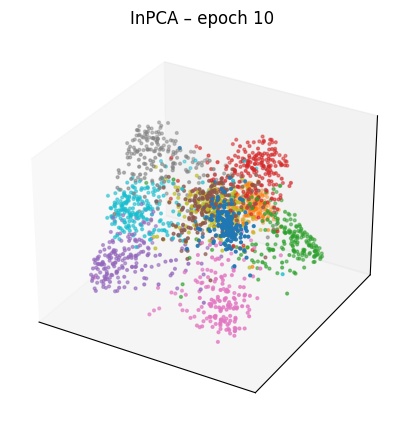

In [9]:
# ----------- choose epoch to plot -----------
epoch_to_plot = 10                # 0, 20, 100 … repeat as wanted
P   = np.load(f"{project_root}/data/probs_epoch{epoch_to_plot}.npy")
lab = test_dataset.targets.numpy()     # true digits 0-9

# ----------- subsample to 2000 images -----------
N = 2000
idx = np.random.choice(len(P), size=N, replace=False)
P_sub = P[idx]
lab_sub = lab[idx]

# ----------- InPCA embedding -----------
coords, eigvals = inpca_embed_intensive(P_sub)   # (N, 3)

# ----------- 3D plot -----------
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2],
           c=lab_sub, cmap='tab10', s=4)
ax.set_title(f"InPCA – epoch {epoch_to_plot}")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.show()

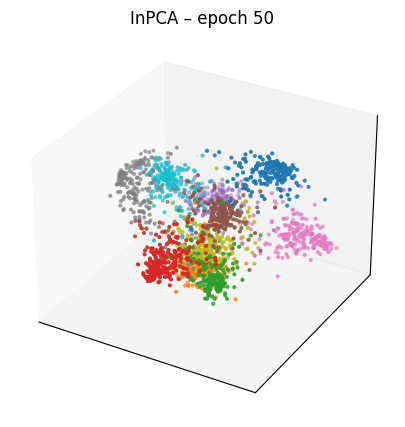

In [16]:
# ----------- choose epoch to plot -----------
epoch_to_plot = 50                # 0, 20, 100 … repeat as wanted
P   = np.load(f"{project_root}/data/probs_epoch{epoch_to_plot}.npy")
lab = test_dataset.targets.numpy()     # true digits 0-9

# ----------- subsample to 2000 images -----------
N = 2000
idx = np.random.choice(len(P), size=N, replace=False)
P_sub = P[idx]
lab_sub = lab[idx]

# ----------- InPCA embedding -----------
coords, eigvals = inpca_embed_intensive(P_sub)   # (N, 3)

# ----------- 3D plot -----------
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2],
           c=lab_sub, cmap='tab10', s=4)
ax.set_title(f"InPCA – epoch {epoch_to_plot}")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.show()

# # ----------- sign mask (True where λ < 0) -----------
# sign_mask = eigvals < 0        # shape (3,)

# # For every point: does it have any contribution along a negative axis?
# neg_weight = np.abs(coords[:, sign_mask]).sum(axis=1)     # (N,)
# neg_flag   = neg_weight > 1e-10                           # boolean mask

# # Plot style: normal points solid; “imaginary” points faded + black edge
# fig = plt.figure(figsize=(6, 5))
# ax  = fig.add_subplot(111, projection='3d')

# # first plot the negative-axis points (faded)
# ax.scatter(coords[neg_flag, 0],
#            coords[neg_flag, 1],
#            coords[neg_flag, 2],
#            c=lab_sub[neg_flag], cmap='tab10', s=4,
#            alpha=0.35, edgecolors='k', linewidths=0.25)

# # then plot the purely positive-axis points (solid)
# ax.scatter(coords[~neg_flag, 0],
#            coords[~neg_flag, 1],
#            coords[~neg_flag, 2],
#            c=lab_sub[~neg_flag], cmap='tab10', s=4,
#            alpha=1.0, edgecolors='none')

# ax.set_title(f"InPCA – epoch {epoch_to_plot}")
# ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
# plt.show()

In [ ]:
# ADD PLOTS